# Task 1: Word Embeddings (10 points)

This notebook will guide you through all steps necessary to train a word2vec model (Detailed description in the PDF).

## Imports

This code block is reserved for your imports. 

You are free to use the following packages: 

(List of packages)

In [ ]:
# Imports
from math import sqrt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import string
import timeit
import torch
from torch import nn
import torch.functional as F
import torch.nn.functional as F
import re
import os
import sys
import warnings
import seaborn as sns


# To store in and import files from google drive

# from google.colab import drive
# drive.mount('/content/drive2/')
# data_file_location = "/content/drive2/MyDrive/nn_dataset/final/"
# os.chdir(data_file_location)

# end of google drive mount related code

print(f'Current Directory: {os.getcwd()}')

# arr = os.listdir()
# print(', '.join(arr))

from early_stopping import EarlyStopping
warnings.filterwarnings('ignore')

Current Directory: c:\Users\kazi.rabi\Documents\un\nn


# 1.1 Get the data (0.5 points)

The Hindi portion HASOC corpus from [github.io](https://hasocfire.github.io/hasoc/2019/dataset.html) is already available in the repo, at data/hindi_hatespeech.tsv . Load it into a data structure of your choice. Then, split off a small part of the corpus as a development set (~100 data points).

If you are using Colab the first two lines will let you upload folders or files from your local file system.

In [ ]:
dataf = pd.read_csv('data/hindi_hatespeech.tsv', delimiter='\t')

In [ ]:
# Set device to cpu or gpu
CUDA_ID = None
DEVICE = None
if torch.cuda.is_available():
    CUDA_ID = torch.cuda.current_device()
    DEVICE = torch.device('cuda')
    if log:
        print("Running On GPU")
else:
    DEVICE = "cpu"

In [ ]:
sentences = [text.split() for text in list(dataf.text)]
dataf.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_hi_5556,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",NOT,NONE,NONE
1,hasoc_hi_5648,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,HOF,PRFN,UNT
2,hasoc_hi_164,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,HOF,PRFN,TIN
3,hasoc_hi_3530,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",NOT,NONE,NONE
4,hasoc_hi_5206,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,NOT,NONE,NONE


Some functions to preprocess the texts along with some helper functions are put here for better organization of the notebook

In [ ]:
def load_stopwords(filename):
    file = open(filename, "r", encoding="utf8")
    return [x[:-1] for x in file]

def remove_username(text):
    at ='@'
    text = ' '.join(list(map(lambda word : word if word[0] != at else ' ', text))).split()
    return text


def remove_punctuations(text):
    punc = string.punctuation + "…।"
    text = ''.join([ch if ch not in punc else ' ' for ch in ' '.join(text)]).split()
    return text

def remove_url(text):
    text = re.sub('http[s]?://\S+', '', ' '.join(text))
    return text.split()

def remove_stopwords(text):
    text = ' '.join([word.strip() if word.strip() not in stopwords  else ' ' for word in text]).split()
    return text

def remove_single_english_char_and_digit(text):
    single_let_n_sym = [c for c in string.ascii_letters + string.digits + '”सहगईइ॥√ﷺ》तजओप“मक¸‍✅उख–भॐर¶°़】•चए—©अऋब']
    hidden_char = 8294
    text = ' '.join([' ' if (word in single_let_n_sym) or (len(word) == 1 and ord(word) == hidden_char) else word for word in text]).split()
    return text


def preprocess(texts):
    print("Preprocessing started")
    start = timeit.default_timer()

    texts = list(map(remove_username, texts))
    texts = list(map(remove_url, texts))
    texts = list(map(remove_punctuations, texts))
    texts = list(map(remove_stopwords, texts))
    texts = list(map(remove_single_english_char_and_digit, texts))
    texts = list(map(lambda text : [word.lower() for word in text], texts))

    stop = timeit.default_timer()
    print("Preprocessing finished.\nPreprocessing Took " + str(stop - start) + " Seconds\n\n")

    return texts

def build_vocab(texts, padding = '___PAD___', unknown = '___UNK___'): # prepends a padding token and an unknown token at index 0 and 1
    return [padding] + [unknown] + list(set(word for text in texts for word in text))

# Plots the distribution and cdf of preprocessed sentance lengths
def summary_stat(dataf, sentences):
    dataf["preprocessed_sen_len"] = [len(text) for text in sentences]

    print(dataf.preprocessed_sen_len.describe())

    plt.hist(list(dataf.preprocessed_sen_len), bins= 100, density = True, cumulative = True, label = 'CDF: Preprocessed Sentence Lenght', histtype='step', alpha=0.55, color='purple')
    plt.show()
    sns.distplot(dataf.preprocessed_sen_len, hist = True, kde = True, 
             bins = int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel = "Preprocessed Sentence Length")

    print("")

## 1.2 Data preparation (0.5 + 0.5 points)

* Prepare the data by removing everything that does not contain information. 
User names (starting with '@') and punctuation symbols clearly do not convey information, but we also want to get rid of so-called [stopwords](https://en.wikipedia.org/wiki/Stop_word), i. e. words that have little to no semantic content (and, but, yes, the...). Hindi stopwords can be found [here](https://github.com/stopwords-iso/stopwords-hi/blob/master/stopwords-hi.txt) Then, standardize the spelling by lowercasing all words.
Do this for the development section of the corpus for now.

* What about hashtags (starting with '#') and emojis? Should they be removed too? Justify your answer in the report, and explain how you accounted for this in your implementation.

In [ ]:
stopwords = load_stopwords('data/stopwords-hi.txt')
print(f'Example sentence before preprocessing:\n{sentences[4]}\n\n')
sentences = preprocess(sentences)
print(f'Same sentence after preprocessing: {sentences[4]}')

Example sentence before preprocessing:
['चमकी', 'बुखार:', 'विधानसभा', 'परिसर', 'में', 'आरजेडी', 'का', 'प्रदर्शन,', 'तेजस्वी', 'यादव', 'नदारद', '#biharencephalitisdeaths', 'https://abpnews.abplive.in/bihar-news/aes-deaths-rjd-protest-in-vidhan-sabha-campus-but-tejashwi-yadav-was-not-present-1158748', '…', '(रिपोर्ट-', '@kumarprakash4u', ')']


Preprocessing started
Preprocessing finished.
Preprocessing Took 0.6862264999999752 Seconds


Same sentence after preprocessing: ['चमकी', 'बुखार', 'विधानसभा', 'परिसर', 'आरजेडी', 'प्रदर्शन', 'तेजस्वी', 'यादव', 'नदारद', 'biharencephalitisdeaths', 'रिपोर्ट']


count    4665.000000
mean       17.702465
std         9.683710
min         0.000000
25%        10.000000
50%        15.000000
75%        25.000000
max        69.000000
Name: preprocessed_sen_len, dtype: float64


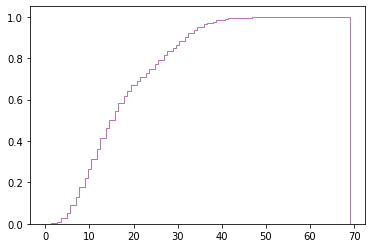

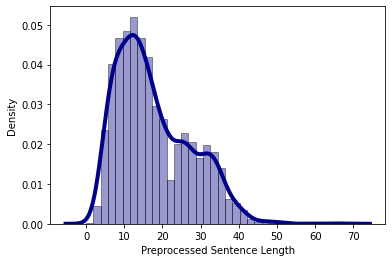

In [ ]:
summary_stat(dataf, sentences)

## 1.3 Build the vocabulary (0.5 + 0.5 points)

The input to the first layer of word2vec is an one-hot encoding of the current word. The output od the model is then compared to a numeric class label of the words within the size of the skip-gram window. Now

* Compile a list of all words in the development section of your corpus and save it in a variable ```V```.

In [ ]:
PADDING = "___PAD___"
V = build_vocab(dev_set)
ONE_HOT_VECTOR_SIZE = len(V)
ONE_HOT_VECTOR_SIZE

1195

In [ ]:
print(f"dev_set Vocabularies length: {ONE_HOT_VECTOR_SIZE}")
print(f"First five words are:")
V[:5]

dev_set Vocabularies length: 1195
First five words are:


['___PAD___', '___UNK___', 'बाज़ार', 'radheradhe', 'काँची']

* Then, write a function ```word_to_one_hot``` that returns a one-hot encoding of an arbitrary word in the vocabulary. The size of the one-hot encoding should be ```len(v)```.

In [ ]:
def word_to_one_hot(word):
    v = [0] * ONE_HOT_VECTOR_SIZE
    v[word_to_index[word]] = 1
    return v

def convert_word_to_index(V):
  w2idx = {}
  for idx, word in enumerate(V):
    w2idx[word] = idx
  return w2idx

# helper function to convert a batch of skip-gram to a batch of one hot vectors for training.
# Utilizes word_to_one_hot function
def batch_word_to_one_hot(batch):
  one_hot_batch = []
  for idx_tensor in batch:
    idx = idx_tensor.item()
    x = word_to_one_hot(V[int(idx)])
    one_hot_batch.append(x)
  return torch.Tensor(one_hot_batch)

## 1.4 Subsampling (0.5 points)

The probability to keep a word in a context is given by:

$P_{keep}(w_i) = \Big(\sqrt{\frac{z(w_i)}{0.001}}+1\Big) \cdot \frac{0.001}{z(w_i)}$

Where $z(w_i)$ is the relative frequency of the word $w_i$ in the corpus. Now,
* Calculate word frequencies
* Define a function ```sampling_prob``` that takes a word (string) as input and returns the probabiliy to **keep** the word in a context.

In [ ]:
# For each word in the vocabulary, the function keeps a count of how many times one particular word appeared in the entire dataset
# Then at the end each word count was devided with the total number of words to get the relatie frequency
def calc_rel_freq(V, texts):
  rel_freq = [0.] * ONE_HOT_VECTOR_SIZE
  total = 0.

  for word in V:
    cnt = 0.
    for text in texts:
      cnt += text.count(word)
    rel_freq[word_to_index[word]] = cnt
    total += cnt

  for word in V:
    rel_freq[word_to_index[word]] = rel_freq[word_to_index[word]] / total;
  
  return rel_freq


def sampling_prob(word_ind):
  rf = rel_freq[word_ind]
  return (sqrt(rf / 0.001) + 1.) * (0.001 / rf)

# 1.5 Skip-Grams (1 point)

Now that you have the vocabulary and one-hot encodings at hand, you can start to do the actual work. The skip gram model requires training data of the shape ```(current_word, context)```, with ```context``` being the words before and/or after ```current_word``` within ```window_size```. 

* Have closer look on the original paper. If you feel to understand how skip-gram works, implement a function ```get_target_context``` that takes a sentence as input and [yield](https://docs.python.org/3.9/reference/simple_stmts.html#the-yield-statement)s a ```(current_word, context)```.

* Use your ```sampling_prob``` function to drop words from contexts as you sample them. 

In [ ]:
# Given a sentence and a window size, the function considers each word as the center and all the neighbouring words that falls under the window size
# to create pairs. But it only neighbouring word if the sampling probability of that word is higher than a random number
def get_target_context(sentence, window_size = 2):
  sentence_to_indices = [word_to_index[word] for word in sentence]
  sentence_len = len(sentence_to_indices)
  for center_ind in range(sentence_len):
    for context_i in range(-window_size, window_size + 1):
      context_ind = center_ind + context_i
      if context_ind == center_ind \
        or context_ind < 0 \
        or context_ind >= sentence_len:
          continue
      if np.random.random() < sampling_prob(sentence_to_indices[context_ind]):
        yield (sentence_to_indices[center_ind], sentence_to_indices[context_ind])

# 1.6 Hyperparameters (0.5 points)

According to the word2vec paper, what would be a good choice for the following hyperparameters? 

* Embedding dimension
* Window size

Initialize them in a dictionary or as independent variables in the code block below. 

In [ ]:
# The parameters defined here was only used for the small set. The paramters were adjusted before the full trainig
# and the explanations for their values are included in the report

# Set hyperparameters
window_size = 2
embedding_size = 300

# More hyperparameters
learning_rate = 0.005
epochs = 50

# 1.7 Pytorch Module (0.5 + 0.5 + 0.5 points)

Pytorch provides a wrapper for your fancy and super-complex models: [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The code block below contains a skeleton for such a wrapper. Now,

* Initialize the two weight matrices of word2vec as fields of the class.

* Override the ```forward``` method of this class. It should take a one-hot encoding as input, perform the matrix multiplications, and finally apply a log softmax on the output layer.

* Initialize the model and save its weights in a variable. The Pytorch documentation will tell you how to do that.

In [ ]:
# Create model 
class Word2Vec(torch.nn.Module):
  def __init__(self, vocab_size, embedding_size = 300):
    super(Word2Vec, self).__init__()
    self.E = nn.Linear(vocab_size, embedding_size, bias = False)
    self.W = nn.Linear(embedding_size, vocab_size)


  def forward(self, one_hot):
    z_e = self.E(one_hot)
    z_w = self.W(z_e)

    return F.log_softmax(z_w, dim = 1)

In [ ]:
def save_model(model, filename):
  torch.save(model.state_dict(), filename)
def load_model(model, filename):
  model.load_state_dict(torch.load(filename), strict=False)

# 1.8 Loss function and optimizer (0.5 points)

Initialize variables with [optimizer](https://pytorch.org/docs/stable/optim.html#module-torch.optim) and loss function. You can take what is used in the word2vec paper, but you can use alternative optimizers/loss functions if you explain your choice in the report.

In [ ]:
# Define optimizer and loss
dev_model = Word2Vec(ONE_HOT_VECTOR_SIZE)
optimizer = torch.optim.Adam(dev_model.parameters(), lr = learning_rate)
criterion = nn.NLLLoss(reduction = "mean")

print(sum(p.numel() for p in dev_model.parameters() if p.requires_grad))
# 10818000

718195


# 1.9 Training the model (3 points)

As everything is prepared, implement a training loop that performs several passes of the data set through the model. You are free to do this as you please, but your code should:

* Load the weights saved in 1.6 at the start of every execution of the code block
* Print the accumulated loss at least after every epoch (the accumulate loss should be reset after every epoch)
* Define a criterion for the training procedure to terminate if a certain loss value is reached. You can find the threshold by observing the loss for the development set.

You can play around with the number of epochs and the learning rate.

In [ ]:
# Helper function to shuffle and create data in batch where the center word is the input and context word as the target/label
def prepare_dataloader(data_set, batch_size = 64, shuffle = True, window_size = 2):
  print("Preparing data loader")
  start = timeit.default_timer()

  data = []
  sentence_counter = 0
  for sentence in data_set:
    for center_idx, context_idx in get_target_context(sentence, window_size = window_size):
      data.append([center_idx, context_idx])
    sentence_counter += 1
    if sentence_counter % 500 == 0:
      print("Processed " + str(sentence_counter) + " sentences")
  train_len = len(data)
  train_loader = torch.utils.data.DataLoader(data, shuffle=shuffle, batch_size = batch_size)

  stop = timeit.default_timer()
  print("Data loader is ready.\nFound "+ str(train_len) +" pairs.\nPreparing Data Loader Took " + str(round((stop - start), 2)) + " Seconds\n\n")

  return train_loader


In [ ]:
# Given a model and a data loader, trains the model using the data from the data loader
def train(model, train_loader, window_size = 2, patience = 5, model_path = "model.pt", batch_size = 64, print_loss = True, print_step = 500, dataset_name = "hindi_dev"):
    print("Training started")
    start = timeit.default_timer()

    model_path = dataset_name + "_w_" + str(window_size) + "_bs_" +str(batch_size) + "_lr_" + str(learning_rate) + "_" + str(start) +".pt"
    early_stopping = EarlyStopping(patience = patience, verbose = True, path = model_path, delta = 1e-3)

    model = model.to(DEVICE)
    losses = []
    total_batches = len(train_loader)
    for iter in range(epochs):
        epoc_loss = 0
        batch_processed = 0
        dots = 0
        model.train()
        for X_orig, Y_orig in train_loader:
            X = batch_word_to_one_hot(X_orig).to(DEVICE)
            Y = Y_orig.to(DEVICE)

            Y_pred = model(X).squeeze()

            loss = criterion(Y_pred, Y)
            epoc_loss += loss.item()
            batch_processed += 1
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if print_loss and ((batch_processed % print_step == 0) or batch_processed == total_batches):
                dots += 1
                print(".", end='')

        losses.append(epoc_loss / batch_processed)
        if print_loss:
            print("\nAvg. loss at epoch " + str(iter + 1) + ": " + str(epoc_loss / batch_processed))
        
        early_stopping(epoc_loss / batch_processed, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    stop = timeit.default_timer()
    print("Restoring the model to the last saved model")
    load_model(model, model_path)
    print("Training finished.\nTraining Took " + str(round((stop - start) / 60, 2)) + " Minutes\n\n")

    return losses

---

In [ ]:
def plot_losses(losses):
  plt.plot(losses)
  plt.xlabel("Number Of Epochs")
  plt.ylabel("Training Loss")
  plt.show()
  print("\n\n")

DEV SET TRAINING STARTED
--------------------------------------------------
Preparing data loader
Data loader is ready.
Found 5962 pairs.
Preparing Data Loader Took 0.01 Seconds


Total batches: 187
Training started
...........
Avg. loss at epoch 1: 6.986334168337246
Validation loss decreased (inf --> 6.986334).  Saving model ...
...........
Avg. loss at epoch 2: 4.878320526949224
Validation loss decreased (6.986334 --> 4.878321).  Saving model ...
...........
Avg. loss at epoch 3: 3.341023981889939
Validation loss decreased (4.878321 --> 3.341024).  Saving model ...
...........
Avg. loss at epoch 4: 3.1049341301229547
Validation loss decreased (3.341024 --> 3.104934).  Saving model ...
...........
Avg. loss at epoch 5: 2.9919937880918943
Validation loss decreased (3.104934 --> 2.991994).  Saving model ...
...........
Avg. loss at epoch 6: 2.9295156626777854
Validation loss decreased (2.991994 --> 2.929516).  Saving model ...
...........
Avg. loss at epoch 7: 2.8746322259545964
Validat

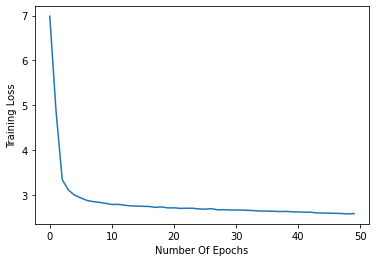




DEV SET TRAINING FINISHED
--------------------------------------------------


In [ ]:
print("DEV SET TRAINING STARTED\n" + str(''.join(['-'] * 50)))
DEVICE = "cpu"
word_to_index = convert_word_to_index(V)
rel_freq = calc_rel_freq(V, dev_set)
batch_size = 32
dev_train_loader = prepare_dataloader(dev_set, batch_size, window_size = window_size)
print(f"Total batches: {len(dev_train_loader)}")
dev_losses = train(dev_model, dev_train_loader, patience = 5, batch_size = batch_size, window_size = window_size, print_step=18)

plot_losses(dev_losses)

print("DEV SET TRAINING FINISHED\n" + str(''.join(['-'] * 50)))

# 1.10 Train on the full dataset (0.5 points)

Now, go back to 1.1 and remove the restriction on the number of sentences in your corpus. Then, reexecute code blocks 1.2, 1.3 and 1.6 (or those relevant if you created additional ones). 

* Then, retrain your model on the complete dataset.

* Now, the input weights of the model contain the desired word embeddings! Save them together with the corresponding vocabulary items (Pytorch provides a nice [functionality](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for this).

FULL SET TRAINING STARTED
--------------------------------------------------


First few words in the Vocabulary:
['___PAD___', '___UNK___', 'chandanichowk', 'protests', 'दिमाग़']


Vocabulary List Length: 18171




Calculating Relative Frequencies
Finished Calculation.
Calculation Took 20.41 Seconds


Preparing data loader
Processed 500 sentences
Processed 1000 sentences
Processed 1500 sentences
Processed 2000 sentences
Processed 2500 sentences
Processed 3000 sentences
Processed 3500 sentences
Processed 4000 sentences
Processed 4500 sentences
Data loader is ready.
Found 676040 pairs.
Preparing Data Loader Took 0.8 Seconds


Total batches: 1321
Training started
.....................
Avg. loss at epoch 1: 8.674125044748333
Validation loss decreased (inf --> 8.674125).  Saving model ...
.....................
Avg. loss at epoch 2: 7.932775580819857
Validation loss decreased (8.674125 --> 7.932776).  Saving model ...
.....................
Avg. loss at epoch 3: 7.298310287065528
Validation 

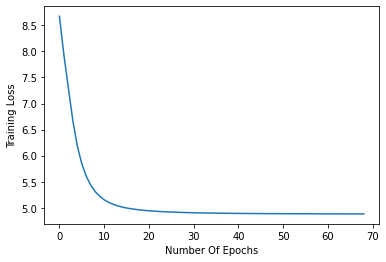




FULL SET TRAINING FINISHED
--------------------------------------------------


In [ ]:
print("FULL SET TRAINING STARTED\n" + str(''.join(['-'] * 50)))
# Set new hyperparameters
window_size = 5
embedding_size = 300
learning_rate = 0.001
epochs = 100
batch_size = 512

dataset = sentences

V = build_vocab(dataset)
print("\n\nFirst few words in the Vocabulary:")
print(V[:5])
ONE_HOT_VECTOR_SIZE = len(V)
print("\n\nVocabulary List Length: " + str(ONE_HOT_VECTOR_SIZE) + "\n\n")

# Define optimizer and loss
training_model = Word2Vec(vocab_size = ONE_HOT_VECTOR_SIZE, embedding_size = embedding_size)
optimizer = torch.optim.Adam(training_model.parameters(), lr = learning_rate)
criterion = nn.NLLLoss(reduction = "mean")

print("\n\nCalculating Relative Frequencies")
start = timeit.default_timer()
word_to_index = convert_word_to_index(V)
rel_freq = calc_rel_freq(V, dataset)

stop = timeit.default_timer()
print("Finished Calculation.\nCalculation Took " + str(round((stop - start), 2)) + " Seconds\n\n")

dataset_loader = prepare_dataloader(dataset, batch_size = batch_size, window_size = window_size)
print(f"Total batches: {len(dataset_loader)}")

training_losses = train(training_model, dataset_loader, window_size = window_size, patience = 5, batch_size = batch_size, dataset_name = "hindi_full", print_step = int(len(dataset_loader)/20))

plot_losses(training_losses)

print("FULL SET TRAINING FINISHED\n" + str(''.join(['-'] * 50)))

with open('hi_em_tl_.001_bs_512_ws_5.txt', 'w') as f:
    print(' '.join([str(ls) for ls in training_losses]), file=f)